# "LeNet-5 CNN"
> "Implementation of LeNet-5 CNN with PyTorch"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [PyTorch, CNN, Computer Vision]
- image: images/
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- use_math: true

<div>
<img src="https://discuss.pytorch.org/uploads/default/original/2X/3/35226d9fbc661ced1c5d17e374638389178c3176.png" width="400" style="margin: 30px auto; display: block; position: relative; left: -30px;" />
</div>

### In this notebook, we will implement the LeNet-5 convolutional neural network architecture with the help of PyTorch. This notebook has been adapted from one of the [tutorials](https://github.com/theevann/amld-pytorch-workshop) presented during a workshop at the Applied Machine Learning Days 2020.

## The LeNet-5 architecture

The LeNet-5 CNN architecture was introduced by Yann LeCun, Leon Bottou, Yosuha Bengio and Patrick Haffner back in 1990's to recognise the handwritten and machine printed characters. Since then, due to its simplicity, it has been used as a first step in teaching Convolutional Neural Networks. 

![](https://pytorch.org/tutorials/_images/mnist.png)

*Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.*

### **Details of the architecture**

Note : In the following, convolutional layers are labeled as Cx, subsampling layers are labeled as Sx, and fully connected
layers are labeled as Fx, where x is the layer index.

+ Convolutional part:


| Layer       | Name | Input channels | Output channels (number of kernels) | Kernel size | stride |
| ----------- | :--: | :------------: | :-------------: | :----: | :----: |
| Convolution |  C1  |       1        |        6        |  5x5   |   1    |
| tanh        |      |       6        |        6        |        |        |
| AvgPooling  |  S2  |       6        |        6        |  2x2   |   2    |
| Convolution |  C3  |       6        |       16        |  5x5   |   1    |
| tanh        |      |       16       |       16        |        |        |
| AvgPooling  |  S4  |       16       |       16        |  2x2   |   2    |
| Convolution |  C5  |       6        |       120       |  5x5   |   1    |
| tanh        |      |      120       |       120       |        |        |


+ Fully Connected part:

| Layer      | Name | Input size | Output size |
| ---------- | :--: | :--------: | :---------: |
| Linear     |  F5  |    120     |     84      |
| tanh       |      |            |             |
| Linear     |  F6  |     84     |     10      |
| LogSoftmax |      |            |             |



---



#### Let's first import some useful modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(precision=3)


import sys
! pip -q install colorama
import colorama # for producing colored terminal text and cursor positioning
from collections import OrderedDict
import matplotlib.pyplot as plt 

#### Let's create our model architecture 

In [2]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv_net = nn.Sequential(OrderedDict([               # We use Ordered dictionary object here.  They remember the order that items were inserted. When iterating over an ordered dictionary, the items are returned in the order their keys were first added.
            ('C1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('Tanh1', nn.Tanh()),
            
            ('S2', nn.AvgPool2d(kernel_size=(2, 2), stride=2)),
            ('C3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('Tanh3', nn.Tanh()),
            
            ('S4', nn.AvgPool2d(kernel_size=(2, 2), stride=2)),
            ('C5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('Tanh5', nn.Tanh()),
        ]))
        
        self.fully_connected = nn.Sequential(OrderedDict([
            ('F6', nn.Linear(120, 84)),
            ('Tanh6', nn.Tanh()),
            ('F7', nn.Linear(84, 10)),
            ('LogSoftmax', nn.LogSoftmax(dim=-1))
        ]))


    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)  # imgs.shape[0] is the batch_size
        output = self.fully_connected(output)
        return output     

Now that we have created our model, let's print the summary to check if everything is correct. 

In [3]:
conv_net = LeNet5()
print(conv_net)

LeNet5(
  (conv_net): Sequential(
    (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (Tanh1): Tanh()
    (S2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
    (C3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (Tanh3): Tanh()
    (S4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
    (C5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (Tanh5): Tanh()
  )
  (fully_connected): Sequential(
    (F6): Linear(in_features=120, out_features=84, bias=True)
    (Tanh6): Tanh()
    (F7): Linear(in_features=84, out_features=10, bias=True)
    (LogSoftmax): LogSoftmax(dim=-1)
  )
)


Our architecture looks perfect !

# Training our CNN

### Train function

Let's define `train_cnn` function 

In [4]:
def train_cnn(model, train_loader, test_loader, device, num_epochs=3, lr=0.1):

  """ Trains the LeNet-5 CNN """

  # We define an optimizer and a loss function
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
      print("=" * 30, "Starting epoch %d" % (epoch + 1), "=" * 30)
      
      model.train()  # Not necessary in our example, but still good practice.
                      # Only models with nn.Dropout and nn.BatchNorm modules require it
              
      # dataloader returns batches of images for 'data' and a tensor with their respective labels in 'labels'
      for batch_idx, (data, labels) in enumerate(train_loader):
          data, labels = data.to(device), labels.to(device)

          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()
          
          if batch_idx % 40 == 0:
              print("Batch %d/%d, Loss=%.4f" % (batch_idx, len(train_loader), loss.item()))
      
      # Compute the train and test accuracy at the end of each epoch
      train_acc = accuracy(model, train_loader, device)
      test_acc = accuracy(model, test_loader, device)
      
      print(colorama.Fore.GREEN, "\nAccuracy on training: %.2f%%" % (100*train_acc))
      print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET)

### Test function

We also need to define an `accuracy` function which can evaluate the model's performance on the train/test set.

In [5]:
def accuracy(model, dataloader, device):
    """ Computes the model's accuracy on the data provided by 'dataloader'
    """
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():  # deactivates autograd, reduces memory usage and speeds up computations
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            predictions = model(data).max(1)[1]  # indices of the maxima along the second dimension
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
        
    return num_correct / num_samples

### Loading the train and test data with *`dataloaders`*


In [6]:
from torchvision import datasets, transforms

transformations = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = datasets.MNIST('./data', 
                            train = True, 
                            download = True,
                            transform = transformations)

test_data = datasets.MNIST('./data', 
                            train = False, 
                            download = True,
                            transform = transformations)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=False)

#### Let's visualize some of the training samples

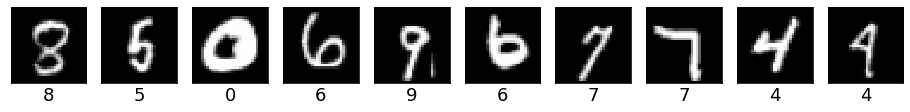

In [7]:
plt.figure(figsize=(16,9))
data, target = next(iter(train_loader))
for i in range(10):
    img = data.squeeze(1)[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.xlabel(target[i].item(), fontsize=18)
    plt.xticks([])
    plt.yticks([])

### Time to start the training!

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if gpu available
conv_net = conv_net.to(device)

train_cnn(conv_net, train_loader, test_loader, device, num_epochs=10, lr=2e-3)

============================== Starting epoch 1 ==============================
Batch 0/235, Loss=2.3098
Batch 40/235, Loss=0.3813
Batch 80/235, Loss=0.3554
Batch 120/235, Loss=0.2120
Batch 160/235, Loss=0.2067
Batch 200/235, Loss=0.1087
 
Accuracy on training: 96.00%
Accuracy on test: 96.18% 
============================== Starting epoch 2 ==============================
Batch 0/235, Loss=0.0964
Batch 40/235, Loss=0.1028
Batch 80/235, Loss=0.0841
Batch 120/235, Loss=0.1043
Batch 160/235, Loss=0.1101
Batch 200/235, Loss=0.0642
 
Accuracy on training: 97.96%
Accuracy on test: 97.83% 
============================== Starting epoch 3 ==============================
Batch 0/235, Loss=0.0439
Batch 40/235, Loss=0.0733
Batch 80/235, Loss=0.0361
Batch 120/235, Loss=0.0412
Batch 160/235, Loss=0.0847
Batch 200/235, Loss=0.0664
 
Accuracy on training: 98.23%
Accuracy on test: 97.68% 
============================== Starting epoch 4 ==============================
Batch 0/235, Loss=0.1003
Batch 40/235, 

Accuracy of 98.58% on the test set, excellent ! 
If one notice carefully, our model already achieved an accuracy of 98.70% after the end of 8th epoch. In further two epochs, we are overfitting our model and that's why the accuracy on the test set drops. This can be avoided by keeping track of the loss values. 

### Let's look at some of the model's predictions

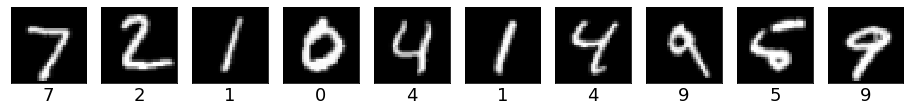

In [12]:
def visualize_predictions(model, dataloader, device):
    data, labels = next(iter(dataloader))
    data, labels = data[:10].to(device), labels[:10]
    predictions = model(data).max(1)[1]
    
    predictions, data = predictions.cpu(), data.cpu()
    
    plt.figure(figsize=(16,9))
    for i in range(10):
        img = data.squeeze(1)[i]
        plt.subplot(1, 10, i+1)
        plt.imshow(img, cmap="gray", interpolation="none")
        plt.xlabel(predictions[i].item(), fontsize=18)
        plt.xticks([])
        plt.yticks([])    
    
visualize_predictions(conv_net, test_loader, device)

Let me know if you have any feedback or comments !